# The e2e Model Lifecycle on SAS Viya Platform

In this notebook, 

1. Build and train the model.
2. Create an API of the model. (Here we have put it in a flask API).
3. Create the requirements file containing all the required libraries.
4. Create the docker file with necessary environment setup and start-up operations.
5. Build the docker image.

I train XGboost model for testing Docker Private ML environment

## Libraries

In [19]:
# Mongo Library

import pymongo

# ML libraries 

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.base import TransformerMixin
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import statsmodels.api as smodel
import xgboost as xgb

# Tool libraries

# import json
# import os
# import requests as req
# import random
# import pickle
# import zipfile
# import urllib
# import base64
# import time
# import sys

# import sasctl

## Utilities

In [3]:
# class DataFrameImputer(TransformerMixin):

#     def __init__(self):
#         """Impute missing values.

#         Columns of dtype object are imputed with the most frequent value 
#         in column.

#         Columns of other types are imputed with mean of column.

#         """
#     def fit(self, X, y=None):

#         self.fill = pd.Series([X[c].value_counts().index[0]
#             if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
#             index=X.columns)

#         return self

#     def transform(self, X, y=None):
#         return X.fillna(self.fill)

## Data Engineering

### Load Data from Mongo

In [8]:
#Connect to mongodb container

conn = pymongo.MongoClient('mongo', 27017)

In [9]:
conn

MongoClient(host=['mongo:27017'], document_class=dict, tz_aware=False, connect=True)

In [10]:
db = conn.training
collection = db.churn_data

In [100]:
df = pd.DataFrame(list(collection.find()))
df.drop('_id', axis=1, inplace=True)
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.3667,1,9,
1,1,1300,70053,68400,HomeImp,Other,7,0,2,121.833,0,14,
2,1,1500,13500,16700,HomeImp,Other,4,0,0,149.467,1,10,
3,1,1500,,,,,,,,,,,
4,0,1700,97800,112000,HomeImp,Office,3,0,0,93.3333,0,14,


### Declare data types

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71520 entries, 0 to 71519
Data columns (total 13 columns):
BAD        71520 non-null int64
LOAN       71520 non-null int64
MORTDUE    71520 non-null object
VALUE      71520 non-null object
REASON     71520 non-null object
JOB        71520 non-null object
YOJ        71520 non-null object
DEROG      71520 non-null object
DELINQ     71520 non-null object
CLAGE      71520 non-null object
NINQ       71520 non-null object
CLNO       71520 non-null object
DEBTINC    71520 non-null object
dtypes: int64(2), object(11)
memory usage: 7.1+ MB


In [102]:
cols = df[df.columns.difference(['BAD','LOAN','REASON','JOB'])].columns
df[cols] = df[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
df['BAD']=df['BAD'].astype('category')

In [103]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366669,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833336,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466660,1.0,10.0,NaN
3,1,1500,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333336,0.0,14.0,NaN


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71520 entries, 0 to 71519
Data columns (total 13 columns):
BAD        71520 non-null category
LOAN       71520 non-null int64
MORTDUE    65304 non-null float32
VALUE      70176 non-null float32
REASON     71520 non-null object
JOB        71520 non-null object
YOJ        65340 non-null float32
DEROG      63024 non-null float32
DELINQ     64560 non-null float32
CLAGE      67824 non-null float32
NINQ       65400 non-null float32
CLNO       68856 non-null float32
DEBTINC    56316 non-null float32
dtypes: category(1), float32(9), int64(1), object(2)
memory usage: 4.2+ MB


### Declare variables 

In [115]:
#target var
target = df.select_dtypes('category').columns

#categorical (nominal and ordinal) variables
class_inputs = list(df.select_dtypes('object').columns) 

#input interval variables
numerical_inputs = list(df.select_dtypes('float32').columns)

inputs = class_inputs + numerical_inputs

print(target)
print(class_inputs)
print(numerical_inputs)
print(inputs)

Index(['BAD'], dtype='object')
['REASON', 'JOB']
['MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
['REASON', 'JOB', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']


In [116]:
df[inputs]

,REASON,JOB,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,HomeImp,Other,25860.0,39025.0,10.5,0.0,0.0,94.366669,1.0,9.0,NaN
1,HomeImp,Other,70053.0,68400.0,7.0,0.0,2.0,121.833336,0.0,14.0,NaN
2,HomeImp,Other,13500.0,16700.0,4.0,0.0,0.0,149.466660,1.0,10.0,NaN
3,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HomeImp,Office,97800.0,112000.0,3.0,0.0,0.0,93.333336,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
71515,DebtCon,Other,57264.0,90185.0,16.0,0.0,0.0,221.808716,0.0,16.0,36.112347
71516,DebtCon,Other,54576.0,92937.0,16.0,0.0,0.0,208.692062,0.0,15.0,35.859970
71517,DebtCon,Other,50370.0,91861.0,14.0,0.0,0.0,213.892715,0.0,16.0,34.340881
71518,DebtCon,Other,48811.0,88934.0,15.0,0.0,0.0,219.600998,0.0,16.0,34.571518


### Impute missing

In [117]:
categorical_imputer = SimpleImputer(missing_values = '', strategy = 'most_frequent')
numerical_imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

# Impute categorical variables

categorical_imputer.fit(df[class_inputs])
categorical_imputed = categorical_imputer.transform(df[class_inputs])
df_categorical_imputed = pd.DataFrame(data=categorical_imputed, columns=class_inputs)
df_categorical_imputed.info()

print('-'*50)

#Impute numerical variables

numerical_imputer.fit(df[numerical_inputs])
numerical_imputed = numerical_imputer.transform(df[numerical_inputs])
df_numerical_imputed = pd.DataFrame(data=numerical_imputed, columns=numerical_inputs)
df_numerical_imputed.info()
df_numerical_imputed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71520 entries, 0 to 71519
Data columns (total 2 columns):
REASON    71520 non-null object
JOB       71520 non-null object
dtypes: object(2)
memory usage: 1.1+ MB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71520 entries, 0 to 71519
Data columns (total 9 columns):
MORTDUE    71520 non-null float64
VALUE      71520 non-null float64
YOJ        71520 non-null float64
DEROG      71520 non-null float64
DELINQ     71520 non-null float64
CLAGE      71520 non-null float64
NINQ       71520 non-null float64
CLNO       71520 non-null float64
DEBTINC    71520 non-null float64
dtypes: float64(9)
memory usage: 4.9 MB


,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,25860.000000,39025.000000,10.500000,0.00000,0.000000,94.366669,1.000000,9.000000,33.779915
1,70053.000000,68400.000000,7.000000,0.00000,2.000000,121.833336,0.000000,14.000000,33.779915
2,13500.000000,16700.000000,4.000000,0.00000,0.000000,149.466660,1.000000,10.000000,33.779915
3,73760.817199,101776.048741,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915
4,97800.000000,112000.000000,3.000000,0.00000,0.000000,93.333336,0.000000,14.000000,33.779915
...,...,...,...,...,...,...,...,...,...
71515,57264.000000,90185.000000,16.000000,0.00000,0.000000,221.808716,0.000000,16.000000,36.112347
71516,54576.000000,92937.000000,16.000000,0.00000,0.000000,208.692062,0.000000,15.000000,35.859970
71517,50370.000000,91861.000000,14.000000,0.00000,0.000000,213.892715,0.000000,16.000000,34.340881
71518,48811.000000,88934.000000,15.000000,0.00000,0.000000,219.600998,0.000000,16.000000,34.571518


### One-Hot encoding for categorical variables

In [118]:
encoder = OneHotEncoder()
encoder.fit(categorical_imputed)
categorical_encoded = encoder.transform(categorical_imputed)

categories = list(np.hstack(encoder.categories_, ))
categories

# print(categorical_encoded.toarray())
df_categorical_encoded = pd.DataFrame(data=categorical_encoded.toarray(), columns=categories)
df_categorical_encoded.info()
df_categorical_encoded

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71520 entries, 0 to 71519
Data columns (total 8 columns):
DebtCon    71520 non-null float64
HomeImp    71520 non-null float64
Mgr        71520 non-null float64
Office     71520 non-null float64
Other      71520 non-null float64
ProfExe    71520 non-null float64
Sales      71520 non-null float64
Self       71520 non-null float64
dtypes: float64(8)
memory usage: 4.4 MB


,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
71515,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
71516,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
71517,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
71518,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### ABT

In [119]:
abt = pd.concat([df[target], df_numerical_imputed, df_categorical_encoded], axis=1)
abt


,BAD,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
0,1,25860.000000,39025.000000,10.500000,0.00000,0.000000,94.366669,1.000000,9.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,70053.000000,68400.000000,7.000000,0.00000,2.000000,121.833336,0.000000,14.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,13500.000000,16700.000000,4.000000,0.00000,0.000000,149.466660,1.000000,10.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,73760.817199,101776.048741,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,97800.000000,112000.000000,3.000000,0.00000,0.000000,93.333336,0.000000,14.000000,33.779915,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71515,0,57264.000000,90185.000000,16.000000,0.00000,0.000000,221.808716,0.000000,16.000000,36.112347,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
71516,0,54576.000000,92937.000000,16.000000,0.00000,0.000000,208.692062,0.000000,15.000000,35.859970,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
71517,0,50370.000000,91861.000000,14.000000,0.00000,0.000000,213.892715,0.000000,16.000000,34.340881,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
71518,0,48811.000000,88934.000000,15.000000,0.00000,0.000000,219.600998,0.000000,16.000000,34.571518,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Model Development

In [127]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(abt[abt.columns.difference(target)], 
                                                                    abt[target], 
                                                                    test_size=0.33, random_state=27513)

In [128]:
%%time

model = xgb.XGBClassifier(max_depth=4,
                        subsample=0.9,
                        objective='binary:logistic',
                        n_estimators=10,
                        learning_rate = 0.1)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train.values.ravel(), early_stopping_rounds=10,
          eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.12843	validation_0-logloss:0.63226	validation_1-error:0.13228	validation_1-logloss:0.63248
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.12766	validation_0-logloss:0.58222	validation_1-error:0.13181	validation_1-logloss:0.58319
[2]	validation_0-error:0.11117	validation_0-logloss:0.53988	validation_1-error:0.11241	validation_1-logloss:0.54121
[3]	validation_0-error:0.12956	validation_0-logloss:0.50989	validation_1-error:0.13151	validation_1-logloss:0.51122
[4]	validation_0-error:0.12628	validation_0-logloss:0.48263	validation_1-error:0.12851	validation_1-logloss:0.48420
[5]	validation_0-error:0.11497	validation_0-logloss:0.45528	validation_1-error:0.11690	validation_1-logloss:0.45718
[6]	validation_0-error:0.11657	validation_0-logloss:0.43159	validation_1-error:0.11821	validation_1-logloss:0.43391
[7]	validation_0-error:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='auto', validate_parameters=False, verbosity=1)

## Model Assessment

In [129]:
dt_misclassification = 1 - metrics.accuracy_score(y_test, model.predict(X_test))
print('Misclassification Rates\n', 'XGBoost :', dt_misclassification)

Misclassification Rates
 XGBoost : 0.10999067875603763


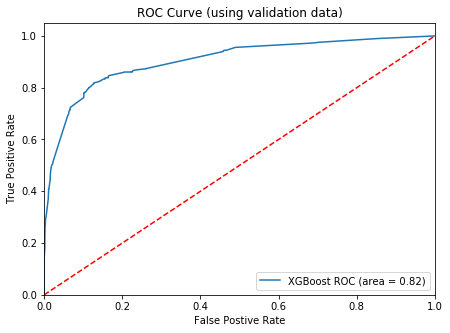

In [130]:
models = [{'label': 'XGBoost','model': model}]

plt.figure(figsize = (7, 5))
for m in models:
    model = m['model']
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (using validation data)')
plt.legend(loc="lower right")
plt.show()

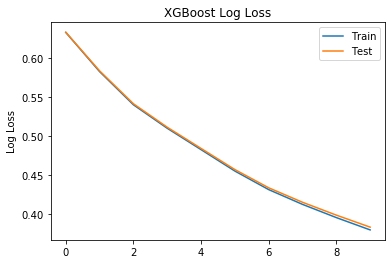

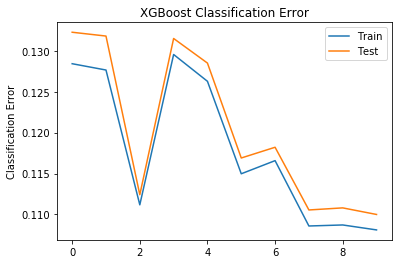

In [131]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()


## Machine Learning Engineering

### Create a pickle with ML pipeline

In [32]:

# Preprocessing interval variables
numeric_transformer = Pipeline(steps=[
    ('imputation', SimpleImputer(strategy='median'))])

# Preprocessing categorical variables
categorical_transformer = Pipeline(steps=[
     ('imputation', SimpleImputer(strategy='most_frequent')),
     ('onehot-encoding', OneHotEncoder(handle_unknown='ignore'))])

# Create preprocessing step
preprocessor = ColumnTransformer(transformers=[
    ('numericals', numeric_transformer, numerical_inputs),
    ('categoricals', categorical_transformer, class_inputs)])

# Model Deployment

For Model Deployment purpose, we need some files:

    0. requirement.txt    
    1. score.py
    2. model.pickle
    3. dmcas_fitstat.json
    4. inputVar.json
    5. outputVar.json
    6. fileMetadata.json
    7. ModelProperties.json


## 1. requirement.txt

In [50]:
! pip freeze > requirement.txt

## 2. Score.py 

## 4. inputVar.py

In [9]:
from utils import modelmanager_service

In [10]:
modelmanager_utils.inputjson()

TypeError: inputjson() missing 3 required positional arguments: 'traindf', 'target', and 'outdir'